# 02-01 : LSTM Baseline

Try to implement an extremely simple baseline for sequence prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import tensorflow as tf
import tensorflow_recommenders as tfrs

from keras import layers
from keras import losses
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

2024-03-04 13:28:32.887331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 13:28:32.887362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 13:28:32.888269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 13:28:32.892884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 13:28:33.387271: W tensorflow/compiler/tf2

## 1. The dataset

We will use the RetailRocket source dataset as prepared for the GRU4Rec paper:
https://github.com/JohnnyFoulds/GRU4Rec/blob/master/notebooks/01_%20preprocess/01-02_retailrocket.ipynb

The dataset is already split into training, validation, and test sets as tab separated files. The columns are:

- `SessionId` - the id of the session. In one session there are one or many items.
- `ItemId` - the id of the item.
- `Time` - the event time.

In [2]:
data_path = '../../data/RetailRocket'
model_path = '../../models/RetailRocket'

# file paths for the data files
train_path = f'{data_path}/retailrocket_processed_view_train_tr.tsv'
validation_path = f'{data_path}/retailrocket_processed_view_train_valid.tsv'
test_path = f'{data_path}/retailrocket_processed_view_test.tsv'

In [3]:
# load the datasets
df_train = pd.read_csv(train_path, sep='\t').sample(frac=0.3, random_state=42)
df_validation = pd.read_csv(validation_path, sep='\t')
df_test = pd.read_csv(test_path, sep='\t')

In [4]:
# head of the training set
display(df_train.head())

,SessionId,ItemId,Time
150593,363804,451942,1433134557529
700326,1684469,441756,1440134153810
673447,1615632,357925,1434672250853
48855,117260,2129,1435772219980
515183,1231963,7804,1432004462904


## 2. Preparing the dataset

In [5]:
# convert the items ids to strings for tokenization
df_train['ItemId'] = df_train['ItemId'].astype(str)
df_validation['ItemId'] = df_validation['ItemId'].astype(str)
df_test['ItemId'] = df_test['ItemId'].astype(str)

### 2.1 Sequence Creation

The first step involves creating sequences of item interactions for each session. This requires grouping the data by SessionId and ordering it within each group based on the Time column. Each sequence represents a series of item interactions within a session.

In [6]:
# Sort by SessionId and Time to ensure the order is correct
df_train_sorted = df_train.sort_values(by=['SessionId', 'Time'])
df_validation_sorted = df_validation.sort_values(by=['SessionId', 'Time'])
df_test_sorted = df_test.sort_values(by=['SessionId', 'Time'])

# Create sequences of ItemIds grouped by SessionId
train_sequences = df_train_sorted.groupby('SessionId')['ItemId'].apply(list)
validation_sequences = df_validation_sorted.groupby('SessionId')['ItemId'].apply(list)
test_sequences = df_test_sorted.groupby('SessionId')['ItemId'].apply(list)

In [7]:
# drop the sessions with only one item
train_sequences = train_sequences[train_sequences.map(len) > 1]

### 2.2 Tokenization (Categorical Features Encoding)

We need to ensure that ItemIds are treated as categorical inputs.

Create a tokenizer to encode ItemIds as integers, 0 and 1 are special values, where 0 should be for padding and 1 for out of vocabulary items.

In [8]:
# get a list of the unique item ids across all datasets
unique_items = pd.concat([df_train, df_validation, df_test]).ItemId.unique()

# use keras to map the item ids to a sequential list of integer values,
# 0 should be for padding and 1 for out of vocabulary items
tokenizer = Tokenizer(num_words=len(unique_items) + 2, oov_token=1)
tokenizer.fit_on_texts(unique_items)

# save the tokenizer
tokenizer_path = f'{model_path}/item_id_tokenizer.json'
with open(tokenizer_path, 'w') as file:
    file.write(tokenizer.to_json())

In [9]:
# tokenize the sequences
train_sequences_tokenized = tokenizer.texts_to_sequences(train_sequences)
validation_sequences_tokenized = tokenizer.texts_to_sequences(validation_sequences)
test_sequences_tokenized = tokenizer.texts_to_sequences(test_sequences)

### 2.3 Padding

To handle sessions of varying lengths, we'll need to pad the sequences so that they all have the same length, making them suitable for batch processing.

In [10]:
# use the last item as the target and the rest as the input
def split_input_target(sequence):
    return sequence[:-1], sequence[-1]

train_sequences_input = list(map(split_input_target, train_sequences_tokenized))
validation_sequences_input = list(map(split_input_target, validation_sequences_tokenized))
test_sequences_input = list(map(split_input_target, test_sequences_tokenized))

In [11]:
# separate into input and target arrays
train_input, y_train = map(list, zip(*train_sequences_input))
validation_input, y_validation = map(list, zip(*validation_sequences_input))
test_input, y_test = map(list, zip(*test_sequences_input))

In [12]:
# Determine the maximum sequence length for padding
max_sequence_length = 10

# pad the sequences
X_train = pad_sequences(train_input, maxlen=max_sequence_length, padding='pre')
X_validation = pad_sequences(validation_input, maxlen=max_sequence_length, padding='pre')
X_test = pad_sequences(test_input, maxlen=max_sequence_length, padding='pre')

### 2.4 Target Encoding

The target values needs to be one-hot encoded.

In [13]:
# get the number of classes from the tokenizer
num_classes = len(tokenizer.word_index) + 1

In [14]:
# convert y values to categorical
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_validation_categorical = to_categorical(y_validation, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

## 3. Model Architecture

In [15]:
# Define the model architecture
model = Sequential([
    layers.Embedding(input_dim=num_classes, output_dim=64), # Set input_dim to the number of unique items
    layers.LSTM(128),
    layers.Dense(units=num_classes, activation='softmax') # Set the number of units to the number of unique items
])

2024-03-04 13:28:36.033303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 13:28:36.061014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 13:28:36.061208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss=losses.SparseCategoricalCrossentropy(),
#     metrics=[tfrs.metrics.FactorizedTopK(
#         tf.data.Dataset.from_tensor_slices(df_train['ItemId']).batch(128))] # Compute FactorizedTopK on the item_id column
# )

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(
    x=X_train, 
    y=y_train_categorical,
    validation_data=(X_validation, y_validation_categorical),
    epochs=10
)

Epoch 1/10


2024-03-04 13:29:34.621103: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-04 13:29:34.675481: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2704d6d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-04 13:29:34.675499: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-04 13:29:34.679767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709551774.744526  596056 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1478/1478 [==============================] - 49s 32ms/step - loss: 10.2586 - accuracy: 6.9798e-04 - val_loss: 10.2298 - val_accuracy: 1.0629e-04
Epoch 2/10
1478/1478 [==============================] - 41s 27ms/step - loss: 9.4704 - accuracy: 0.0016 - val_loss: 10.3929 - val_accuracy: 0.0030
Epoch 3/10
1478/1478 [==============================] - 40s 27ms/step - loss: 8.8109 - accuracy: 0.0057 - val_loss: 10.8486 - val_accuracy: 0.0062
Epoch 4/10
1478/1478 [==============================] - 40s 27ms/step - loss: 7.8715 - accuracy: 0.0173 - val_loss: 11.2466 - val_accuracy: 0.0124
Epoch 5/10
1478/1478 [==============================] - 40s 27ms/step - loss: 6.8623 - accuracy: 0.0496 - val_loss: 11.5912 - val_accuracy: 0.0205
Epoch 6/10
1478/1478 [==============================] - 40s 27ms/step - loss: 5.8778 - accuracy: 0.1223 - val_loss: 11.8999 - val_accuracy: 0.0276
Epoch 7/10
1478/1478 [==============================] - 40s 27ms/step - loss: 4.9196 - accuracy: 0.2420 - val_loss: 12.2

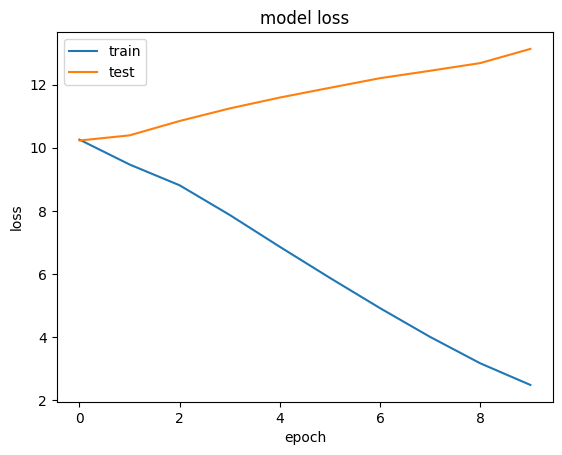

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Evaluation 

In [21]:
def recall_at_k(y_true, y_pred, k=10):
    """
    Compute Recall@K: Fraction of relevant items in the top K predictions
    """
    # Get top K predictions
    top_k_preds = np.argsort(y_pred, axis=1)[:, -k:]
    
    # Check if the true item is among the top K
    relevant = np.sum(np.any(top_k_preds == np.argmax(y_true, axis=1, keepdims=True), axis=1))
    
    return relevant / len(y_true)


In [22]:
def mrr_at_k(y_true, y_pred, k=10):
    """
    Compute MRR@K: Mean Reciprocal Rank of the relevant item if it is in top K predictions
    """
    ranks = np.argsort(np.argsort(-y_pred, axis=1), axis=1) + 1  # Ranks of predictions
    true_ranks = ranks[np.arange(len(y_true)), np.argmax(y_true, axis=1)]  # Find ranks of true items
    
    reciprocal_ranks = np.where(true_ranks <= k, 1 / true_ranks, 0).mean()
    
    return reciprocal_ranks


In [24]:
# Predict probabilities for the test set
y_pred = model.predict(X_test)

# Evaluate Recall@K and MRR@K
recall_k = recall_at_k(y_test_categorical, y_pred, k=10)
mrr_k = mrr_at_k(y_test_categorical, y_pred, k=10)

print(f"Recall@10: {recall_k:.4f}")
print(f"MRR@10: {mrr_k:.4f}")

252/252 [==============================] - 0s 713us/step
Recall@10: 0.0988
MRR@10: 0.0578


In [26]:
y_train_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)